In [1]:
!pip install textblob

In [2]:
import pandas as pd 
import numpy as np
from scipy import sparse
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
import string
import re    
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer   
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBClassifier
from textblob import TextBlob
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from textblob import Word
color = sns.color_palette()
sns.set_style("dark")

tokenizer=TweetTokenizer()
pd.set_option('display.max_rows', 10000)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Data Preprocessing

* Load the dataset

In [4]:
women_clothing=pd.read_excel("Womens Clothing Reviews Data.xlsx")
women_clothing.head()

Product ID        Category Subcategory1 SubCategory2   Location Channel  \
0         767       Initmates     Intimate    Intimates     Mumbai  Mobile   
1        1080         General      Dresses      Dresses  Bangalore  Mobile   
2        1077         General      Dresses      Dresses    Gurgaon  Mobile   
3        1049  General Petite      Bottoms        Pants    Chennai     Web   
4         847         General         Tops      Blouses  Bangalore     Web   

   Customer Age             Review Title  \
0            33                      NaN   
1            34                      NaN   
2            60  Some major design flaws   
3            50         My favorite buy!   
4            47         Flattering shirt   

                                         Review Text  Rating  Recommend Flag  
0  Absolutely wonderful - silky and sexy and comf...       4               1  
1  Love this dress!  it's sooo pretty.  i happene...       5               1  
2  I had such high hopes for this dress and reall...       3               0  
3  I love, love, love this jumpsuit. it's fun, fl...       5               1  
4  This shirt is very flattering to all due to th...       5               1

In [5]:
women_clothing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Product ID      23486 non-null  int64 
 1   Category        23472 non-null  object
 2   Subcategory1    23472 non-null  object
 3   SubCategory2    23472 non-null  object
 4   Location        23486 non-null  object
 5   Channel         23486 non-null  object
 6   Customer Age    23486 non-null  int64 
 7   Review Title    19676 non-null  object
 8   Review Text     22641 non-null  object
 9   Rating          23486 non-null  int64 
 10  Recommend Flag  23486 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 2.0+ MB


In [6]:
women_clothing.columns

Index(['Product ID', 'Category', 'Subcategory1', 'SubCategory2', 'Location',
       'Channel', 'Customer Age', 'Review Title', 'Review Text', 'Rating',
       'Recommend Flag'],
      dtype='object')

### Missing Values

In [8]:
women_clothing.isna().sum()

Product ID           0
Category            14
Subcategory1        14
SubCategory2        14
Location             0
Channel              0
Customer Age         0
Review Title      3810
Review Text        845
Rating               0
Recommend Flag       0
dtype: int64

#### Handle Missing Values

In [10]:
women_clothing.dropna(axis = 0, how= "any", inplace = True)

In [11]:
women_clothing.isna().sum()

Product ID        0
Category          0
Subcategory1      0
SubCategory2      0
Location          0
Channel           0
Customer Age      0
Review Title      0
Review Text       0
Rating            0
Recommend Flag    0
dtype: int64

## a. Performing exploratory analysis on the data to understand the patterns

#### 1. Recommend Flag Distribution

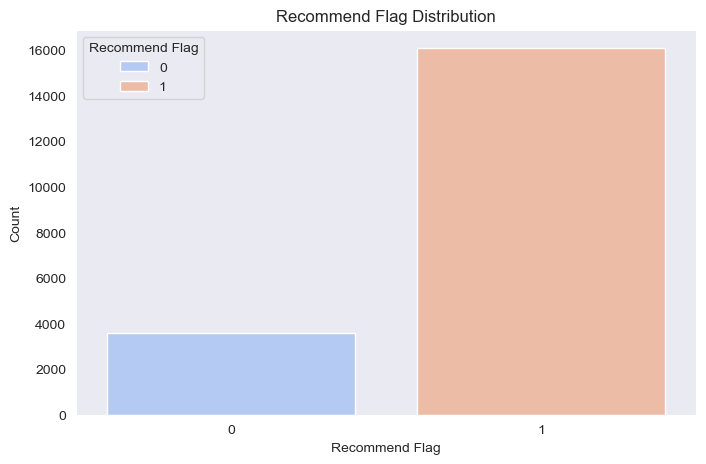

In [13]:
plt.figure(figsize=(8,5))
sns.countplot(x=women_clothing["Recommend Flag"],hue=women_clothing["Recommend Flag"],palette="coolwarm")
plt.title("Recommend Flag Distribution")
plt.xlabel("Recommend Flag")
plt.ylabel("Count")
plt.show()

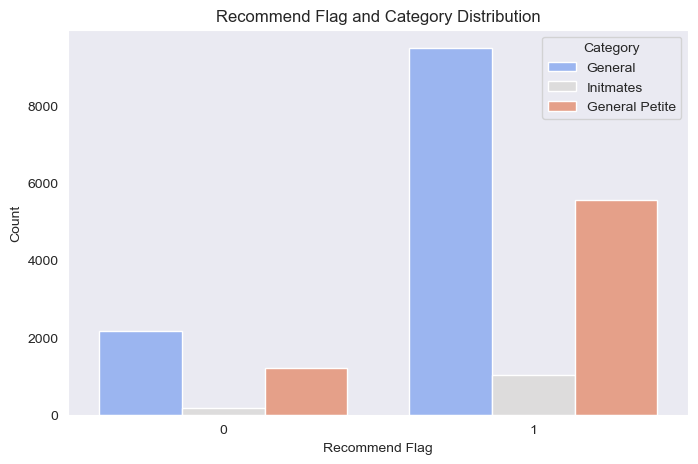

In [14]:
plt.figure(figsize=(8,5))
sns.countplot(x=women_clothing["Recommend Flag"],hue=women_clothing["Category"],palette="coolwarm")
plt.title("Recommend Flag and Category Distribution")
plt.xlabel("Recommend Flag")
plt.ylabel("Count")
plt.show()

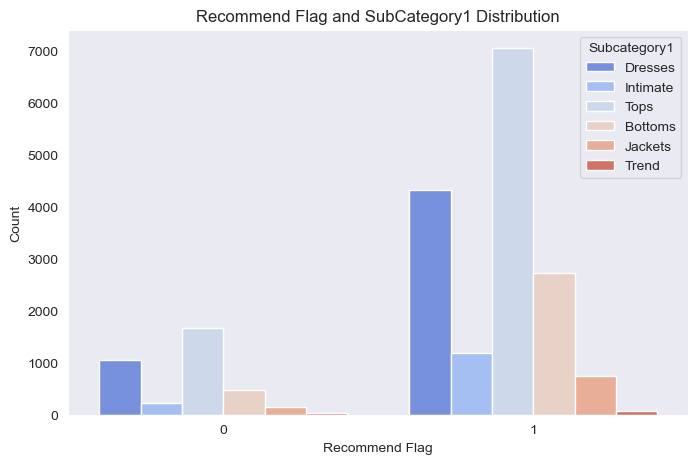

In [15]:
plt.figure(figsize=(8,5))
sns.countplot(x=women_clothing["Recommend Flag"],hue=women_clothing["Subcategory1"],palette="coolwarm")
plt.title("Recommend Flag and SubCategory1 Distribution")
plt.xlabel("Recommend Flag")
plt.ylabel("Count")
plt.show()

#### 2. Rating Distribution

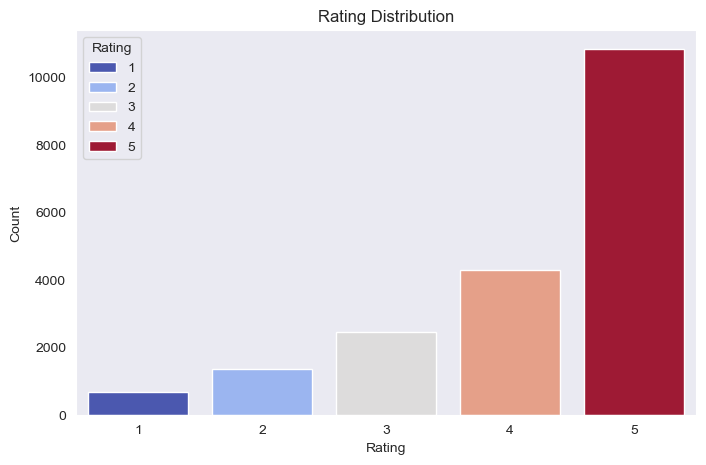

In [17]:
plt.figure(figsize=(8,5))
sns.countplot(x=women_clothing["Rating"],hue=women_clothing["Rating"],palette="coolwarm")
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

#### 3. Customer Age Distribution

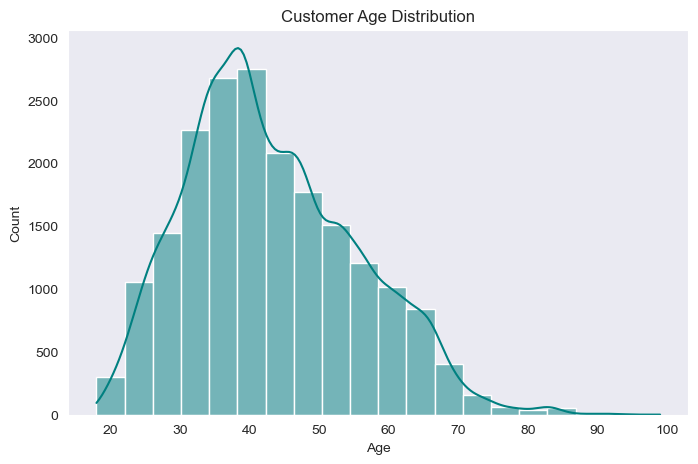

In [19]:
plt.figure(figsize=(8,5))
sns.histplot(women_clothing["Customer Age"],bins=20,kde=True,color="teal")
plt.title("Customer Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

#### 4. Review Count by Category & Location

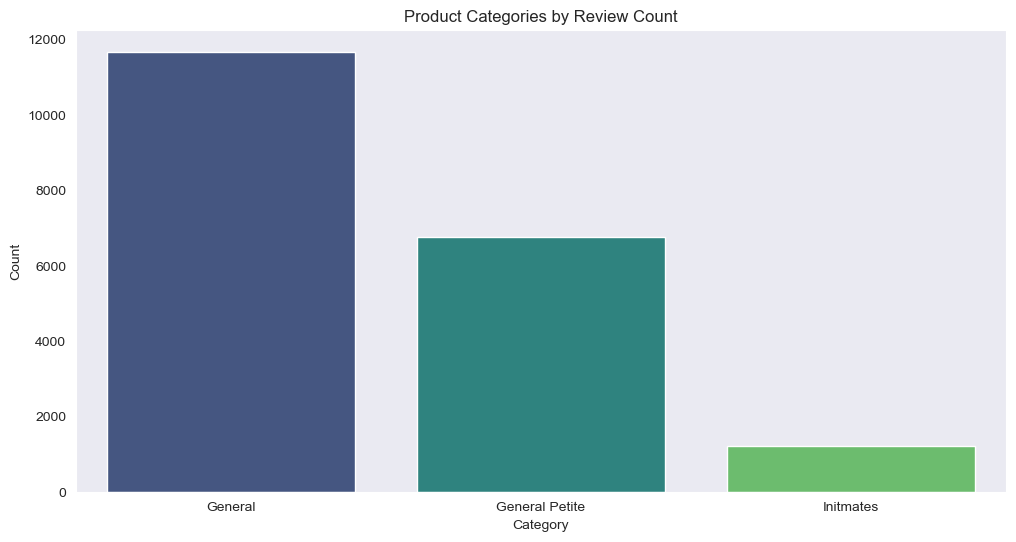

In [21]:
plt.figure(figsize=(12,6))
sns.countplot(x=women_clothing["Category"], order=women_clothing["Category"].value_counts().index, hue=women_clothing["Category"] ,palette="viridis")
plt.title("Product Categories by Review Count")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

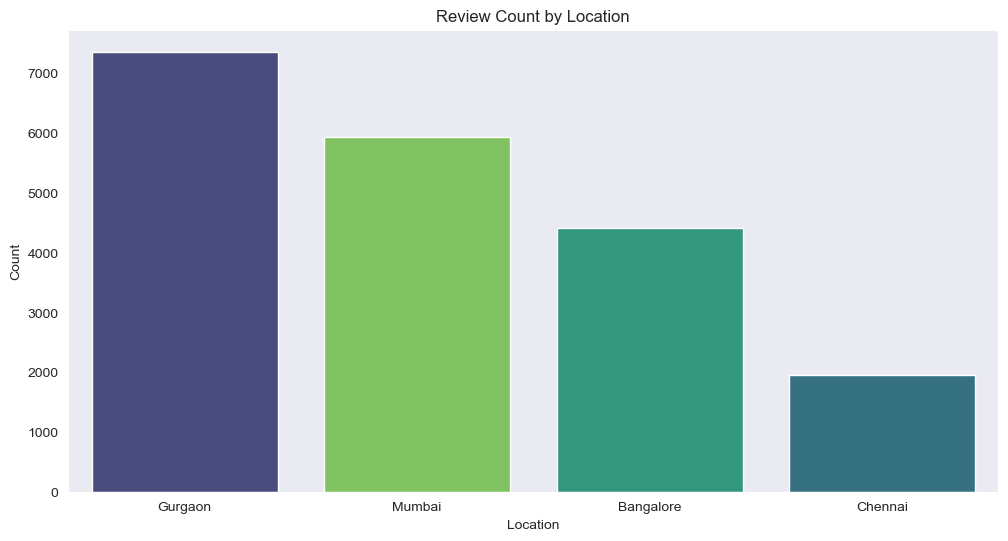

In [22]:
plt.figure(figsize=(12,6))
sns.countplot(x=women_clothing["Location"], order=women_clothing["Location"].value_counts().index, hue=women_clothing["Location"] ,palette="viridis")
plt.title("Review Count by Location")
plt.xlabel("Location")
plt.ylabel("Count")
plt.show()

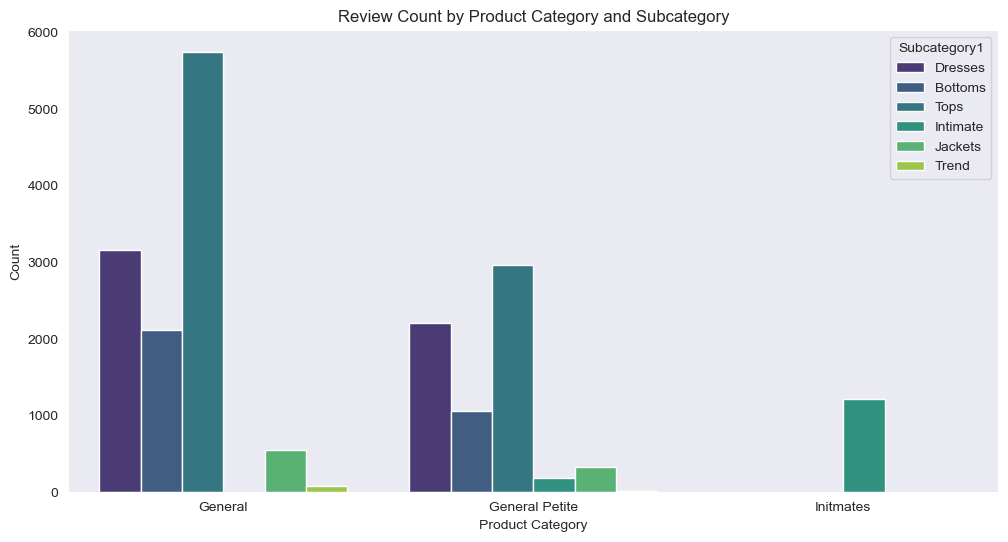

In [23]:
plt.figure(figsize=(12,6))
sns.countplot(x=women_clothing["Category"], order=women_clothing["Category"].value_counts().index, hue=women_clothing["Subcategory1"] ,palette="viridis")
plt.title("Review Count by Product Category and Subcategory")
plt.xlabel("Product Category")
plt.ylabel("Count")
plt.legend(title="Subcategory1")  
plt.show()

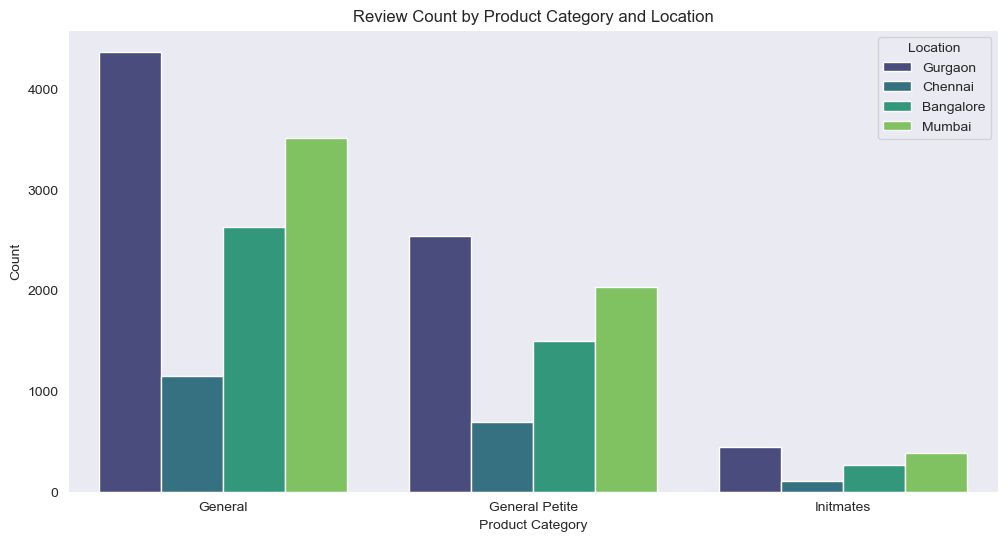

In [24]:
plt.figure(figsize=(12,6))
sns.countplot(x=women_clothing["Category"], order=women_clothing["Category"].value_counts().index, hue=women_clothing["Location"] ,palette="viridis")
plt.title("Review Count by Product Category and Location")
plt.xlabel("Product Category")
plt.ylabel("Count")
plt.legend(title="Location")  
plt.show()

#### 5. Relationship Between Rating & Recommendation

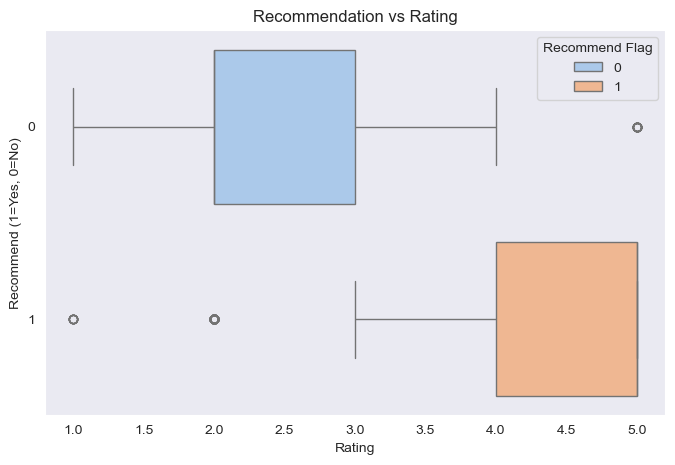

In [26]:
plt.figure(figsize=(8,5))
sns.boxplot(x=women_clothing["Rating"], y=women_clothing["Recommend Flag"].astype(str),hue=women_clothing["Recommend Flag"],palette="pastel")
plt.title("Recommendation vs Rating")
plt.xlabel("Rating")
plt.ylabel("Recommend (1=Yes, 0=No)")
plt.show()

## b. Perform text mining tasks to understand what most frequent words are using for positive sentiment and negative sentiment. Create word clouds for the positive & negative reviews separately.

In [28]:
df=women_clothing
df.head()

Product ID        Category Subcategory1 SubCategory2   Location Channel  \
2        1077         General      Dresses      Dresses    Gurgaon  Mobile   
3        1049  General Petite      Bottoms        Pants    Chennai     Web   
4         847         General         Tops      Blouses  Bangalore     Web   
5        1080         General      Dresses      Dresses    Gurgaon     Web   
6         858  General Petite         Tops        Knits    Gurgaon  Mobile   

   Customer Age             Review Title  \
2            60  Some major design flaws   
3            50         My favorite buy!   
4            47         Flattering shirt   
5            49  Not for the very petite   
6            39     Cagrcoal shimmer fun   

                                         Review Text  Rating  Recommend Flag  
2  I had such high hopes for this dress and reall...       3               0  
3  I love, love, love this jumpsuit. it's fun, fl...       5               1  
4  This shirt is very flattering to all due to th...       5               1  
5  I love tracy reese dresses, but this one is no...       2               0  
6  I aded this in my basket at hte last mintue to...       5               1

In [29]:
df["Review Text"]=df["Review Text"].astype(str)
df["Sentiment_Score"]=df["Review Text"].apply(lambda x:TextBlob(x).sentiment.polarity)

In [30]:
df["Sentiment_Cat"]=np.where(df["Sentiment_Score"]>0.1,"Positive",np.where(df["Sentiment_Score"]<0.1,"Negative","Neutral"))

In [31]:
df.head()

Product ID        Category Subcategory1 SubCategory2   Location Channel  \
2        1077         General      Dresses      Dresses    Gurgaon  Mobile   
3        1049  General Petite      Bottoms        Pants    Chennai     Web   
4         847         General         Tops      Blouses  Bangalore     Web   
5        1080         General      Dresses      Dresses    Gurgaon     Web   
6         858  General Petite         Tops        Knits    Gurgaon  Mobile   

   Customer Age             Review Title  \
2            60  Some major design flaws   
3            50         My favorite buy!   
4            47         Flattering shirt   
5            49  Not for the very petite   
6            39     Cagrcoal shimmer fun   

                                         Review Text  Rating  Recommend Flag  \
2  I had such high hopes for this dress and reall...       3               0   
3  I love, love, love this jumpsuit. it's fun, fl...       5               1   
4  This shirt is very flattering to all due to th...       5               1   
5  I love tracy reese dresses, but this one is no...       2               0   
6  I aded this in my basket at hte last mintue to...       5               1   

   Sentiment_Score Sentiment_Cat  
2         0.073675      Negative  
3         0.550000      Positive  
4         0.512891      Positive  
5         0.178750      Positive  
6         0.133750      Positive

Sentiment Category Distribution:
 Sentiment_Cat
Positive    16189
Negative     3450
Neutral        23
Name: count, dtype: int64


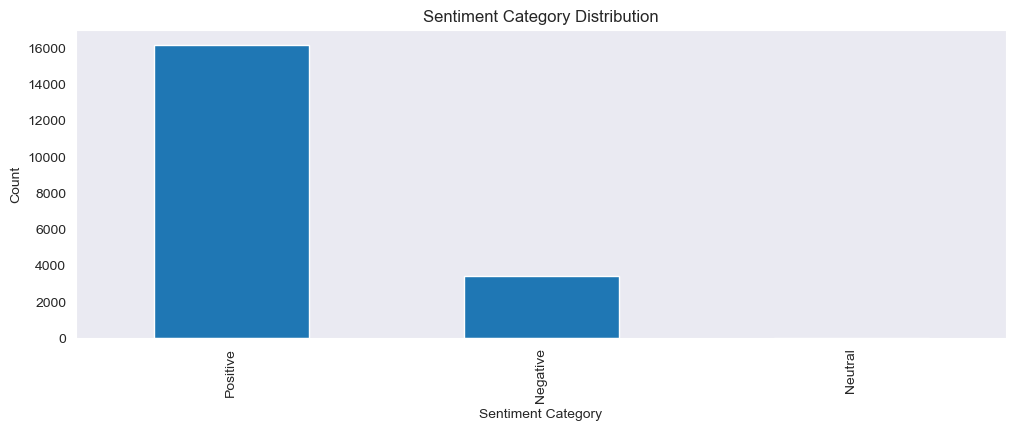

In [32]:
print("Sentiment Category Distribution:\n",df["Sentiment_Cat"].value_counts())
plt.figure(figsize=(12,4))
df["Sentiment_Cat"].value_counts().plot(kind="bar")
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.title("Sentiment Category Distribution")
plt.show()

In [33]:
pd.crosstab(df["Sentiment_Cat"],df["Rating"])

Rating           1    2     3     4     5
Sentiment_Cat                            
Negative       360  610   772   776   932
Neutral          2    4     6     5     6
Positive       329  746  1686  3508  9920

## Dividing the Dataframe(df) into three Dataframe(df_pos,df_neg,df_neu)

In [35]:
df_pos=df[(df["Sentiment_Cat"]=="Positive")]["Review Text"]
df_neg=df[(df["Sentiment_Cat"]=="Negative")]["Review Text"]
df_neu=df[(df["Sentiment_Cat"]=="Neutral")]["Review Text"]

In [36]:
df_pos

3        I love, love, love this jumpsuit. it's fun, fl...
4        This shirt is very flattering to all due to th...
5        I love tracy reese dresses, but this one is no...
6        I aded this in my basket at hte last mintue to...
7        I ordered this in carbon for store pick up, an...
                               ...                        
23479    So i wasn't sure about ordering this skirt bec...
23481    I was very happy to snag this dress at such a ...
23483    This fit well, but the top was very see throug...
23484    I bought this dress for a wedding i have this ...
23485    This dress in a lovely platinum is feminine an...
Name: Review Text, Length: 16189, dtype: object

In [37]:
df_neg

2        I had such high hopes for this dress and reall...
8        I love this dress. i usually get an xs but it ...
10       Dress runs small esp where the zipper area run...
14       This is a nice choice for holiday gatherings. ...
22       First of all, this is not pullover styling. th...
28       I have several of goodhyouman shirts and i get...
33       I ordered this 3 months ago, and it finally ca...
44       Tried this on today at my local retailer and h...
61       3 tags sewn in, 2 small (about 1'' long) and 1...
72       I have a short torso and this works well for m...
77       The zipper broke on this piece the first time ...
78       I usually size up with this brand. small was p...
84       I received this shirt in my typical xs and it ...
105      I bought this lovely silk/velvet shirt in the ...
110      This is so thin and poor quality. especially f...
114      The design/shape of the dress are quite flatte...
116      Prior reviewer nailed it with the summary of t.

## Creating user defined functions for clean the text data

In [39]:
stop_words=set(stopwords.words('english') + ['the', 'me', 'how', 'what', 'like', 'would', 'really'])
lem=WordNetLemmatizer()

# Define a function to clean text
def clean_text(text):
    
    text=text.lower()  # Lowercase
    text=re.sub(r'\d+', '', text)  # Remove digits
    text=text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text=text.strip()  # Strip whitespace
    text=' '.join([lem.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

In [40]:
df_pos=df_pos.apply(clean_text)
df_neg=df_neg.apply(clean_text)

In [41]:
df_pos

3        love love love jumpsuit fun flirty fabulous ev...
4        shirt flattering due adjustable front tie perf...
5        love tracy reese dress one petite foot tall us...
6        aded basket hte last mintue see look person st...
7        ordered carbon store pick ton stuff always try...
                               ...                        
23479    wasnt sure ordering skirt couldnt see person f...
23481    happy snag dress great price easy slip flatter...
23483    fit well top see never worked im glad able try...
23484    bought dress wedding summer cute unfortunately...
23485    dress lovely platinum feminine fit perfectly e...
Name: Review Text, Length: 16189, dtype: object

In [42]:
df_neg

2        high hope dress wanted work initially ordered ...
8        love dress usually get x run little snug bust ...
10       dress run small esp zipper area run ordered sp...
14       nice choice holiday gathering length graz knee...
22       first pullover styling side zipper wouldnt pur...
28       several goodhyouman shirt get many compliment ...
33       ordered month ago finally came back order huge...
44       tried today local retailer comfortable flatter...
61       tag sewn small long huge x itchy cut thread le...
72       short torso work well c bought there much stre...
77       zipper broke piece first time wore disappointi...
78       usually size brand small perfect lb top luxuri...
84       received shirt typical x fit perfectly im craz...
105      bought lovely silkvelvet shirt quotskyquot col...
110      thin poor quality especially price felt thin p...
114      designshape dress quite flattering flirty femi...
116      prior reviewer nailed summary dress definitely.

### Vectorization (Count, Tfidf) for positive sentiments

In [44]:
count_vect_pos=CountVectorizer  ( analyzer='word',
                                  token_pattern=r'\w{1,}', 
                                  ngram_range=(1, 1), 
                                  min_df=5, 
                                  encoding='latin-1',
                                  max_features=800
                                  )
pos_Count=count_vect_pos.fit_transform(df_pos)

In [45]:
pos_Count.shape

(16189, 800)

## View the document term metrics for positive sentiments

In [47]:
dtm=pos_Count.toarray()
pd.DataFrame(dtm,columns=count_vect_pos.get_feature_names_out())

able  absolutely  across  actually  add  added  addition  adorable  \
0         0           0       0         0    0      0         0         0   
1         0           0       0         0    0      0         0         0   
2         0           0       0         0    0      0         0         0   
3         0           0       0         0    0      0         0         0   
4         0           0       0         0    0      0         0         0   
...     ...         ...     ...       ...  ...    ...       ...       ...   
16184     0           0       0         0    0      0         0         0   
16185     0           0       0         0    0      0         0         0   
16186     1           0       0         0    0      0         0         0   
16187     0           0       0         0    0      0         0         0   
16188     0           0       0         0    0      0         0         0   

       adore  ag  ...  xl  xx  year  yellow  yes  yesterday  yet  youre  zip  \
0          0   0  ...   0   0     0       0    0          0    0      0    0   
1          0   0  ...   0   0     0       0    0          0    0      0    0   
2          0   0  ...   0   0     0       0    0          0    0      0    0   
3          0   0  ...   0   0     0       0    0          0    0      0    0   
4          0   0  ...   0   1     0       0    0          0    0      0    0   
...      ...  ..  ...  ..  ..   ...     ...  ...        ...  ...    ...  ...   
16184      0   0  ...   0   0     0       0    0          0    0      0    0   
16185      0   0  ...   0   0     0       0    0          0    0      0    0   
16186      0   0  ...   0   0     0       0    0          0    0      0    0   
16187      0   0  ...   0   0     0       0    0          0    0      0    0   
16188      0   0  ...   0   0     0       0    0          0    0      0    0   

       zipper  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
16184       0  
16185       0  
16186       0  
16187       0  
16188       0  

[16189 rows x 800 columns]

## Word frequencies for positive sentiments

In [49]:
x=pd.DataFrame(dtm,columns=count_vect_pos.get_feature_names_out())
pos_word_frequency=pd.DataFrame(x.apply(sum),columns=["frequency"])

In [50]:
# Sort the words by frequency in descending order
top_50_pos_word=pos_word_frequency.sort_values(by='frequency', ascending=False).head(50)
top_50_pos_word

frequency
dress             8268
fit               7990
love              7037
size              6714
top               6561
color             5238
look              5141
great             5030
wear              4756
im                4351
fabric            3478
perfect           3196
small             2688
ordered           2669
flattering        2651
one               2640
little            2555
soft              2528
comfortable       2460
well              2447
nice              2447
cute              2277
beautiful         2276
bought            2227
bit               2182
back              2080
length            2033
large             2014
jean              2014
material          1978
much              1962
sweater           1944
work              1857
shirt             1852
also              1800
petite            1798
got               1778
run               1756
long              1688
waist             1677
skirt             1660
short             1638
think             1617
pretty            1600
quality           1592
make              1585
feel              1573
good              1565
medium            1560
x                 1548

## Word Cloud for the Positive Sentiments

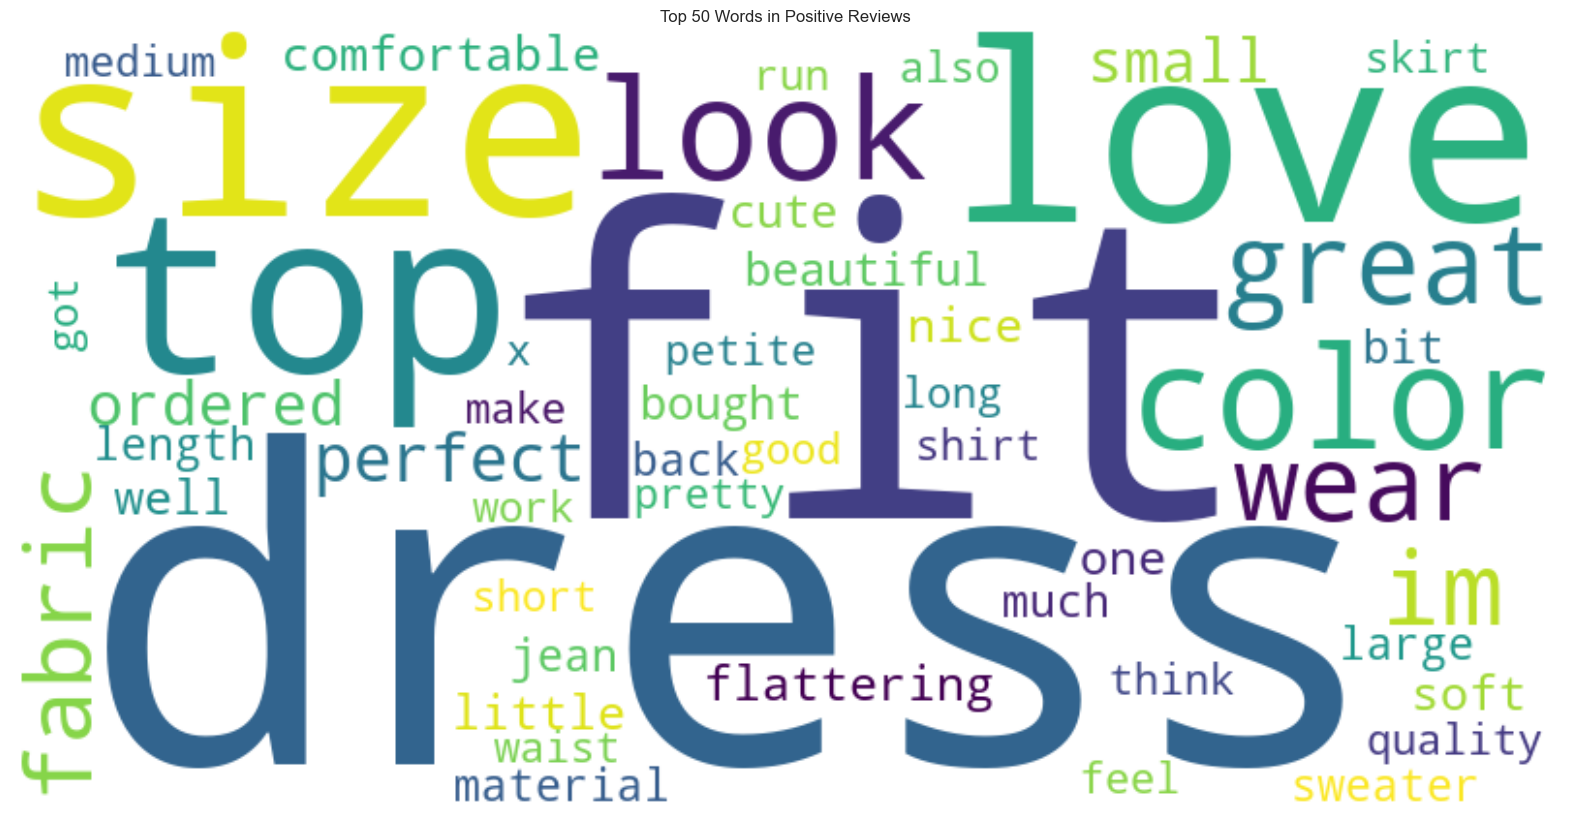

In [52]:
freq_dict=top_50_pos_word["frequency"].to_dict()
wordcloud=WordCloud(width=800, height=400, background_color='white')\
    .generate_from_frequencies(freq_dict)
# Plot the word cloud
plt.figure(figsize=(20,85))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Top 50 Words in Positive Reviews")
plt.show()


## Vectorization (Count, Tfidf) for Negative sentiments

In [54]:
count_vect_neg=CountVectorizer( analyzer='word',
                                token_pattern=r'\w{1,}', 
                                ngram_range=(1, 1), 
                                min_df=5, 
                                encoding='latin-1',
                                max_features=800
                                )
neg_Count=count_vect_neg.fit_transform(df_neg)

In [55]:
neg_Count.shape

(3450, 800)

## View the document term metrics for Negative sentiments

In [57]:
dtm_n=neg_Count.toarray()
pd.DataFrame(dtm_n,columns=count_vect_neg.get_feature_names_out())

able  absolutely  across  actually  add  added  addition  adorable  \
0        0           0       0         0    0      0         0         0   
1        0           0       0         0    0      0         0         0   
2        0           0       0         0    0      0         0         0   
3        0           0       0         0    0      0         0         0   
4        0           0       0         0    0      0         0         0   
5        0           0       0         0    0      0         0         0   
6        0           0       0         0    0      0         0         0   
7        0           0       1         0    0      0         0         0   
8        0           0       0         0    0      0         0         0   
9        0           0       0         0    0      0         0         0   
10       0           0       0         1    0      0         0         0   
11       0           0       0         0    0      0         0         0   
12       0           0       0         0    1      0         0         0   
13       0           0       0         0    0      0         0         0   
14       0           0       0         0    0      0         0         0   
15       0           0       0         0    0      0         0         0   
16       0           0       0         0    0      0         0         0   
17       0           0       0         0    0      0         0         0   
18       0           0       0         0    0      0         0         0   
19       0           0       0         0    0      0         0         0   
20       0           0       0         0    0      0         0         0   
21       0           0       0         0    0      0         0         1   
22       0           0       0         0    0      0         0         0   
23       0           0       0         0    0      0         0         0   
24       0           0       0         0    0      0         0         0   
25       0           0       0         0    0      0         0         0   
26       0           0       0         0    0      0         0         0   
27       0           0       0         0    0      0         0         0   
28       0           0       0         0    0      0         0         0   
29       0           0       0         0    0      0         0         0   
30       0           0       0         0    0      0         0         0   
31       0           0       0         0    0      0         0         0   
32       0           0       0         0    0      0         0         0   
33       0           0       0         0    0      0         1         0   
34       0           0       0         0    0      0         0         0   
35       0           0       0         0    0      0         0         0   
36       0           0       0         0    0      0         0         0   
37       0           0       0         0    0      0         0         0   
38       0           0       0         0    0      0         0         0   
39       0           0       0         0    0      0         0         0   
40       0           0       0         0    0      0         0         0   
41       0           0       0         0    0      0         0         0   
42       0           0       0         0    0      0         0         0   
43       0           0       0         0    0      0         0         0   
44       0           0       0         0    0      0         0         0   
45       0           0       0         0    0      0         0         0   
46       0           0       0         0    0      0         0         0   
47       0           0       0         0    0      0         0         0   
48       0           0       0         0    0      0         0         0   
49       0           0       0         0    0      0         0         0   
50       0           0       0         0    0      0         0         0   
51       0           0       0         0    0      0  

## Word frequencies for Negative sentiments

In [59]:
x1=pd.DataFrame(dtm_n,columns=count_vect_neg.get_feature_names_out())
neg_word_frequency=pd.DataFrame(x1.apply(sum),columns=["frequency"])

In [60]:
# Sort the words by frequency in descending order and get top 50
top_50_neg_word=neg_word_frequency.sort_values(by='frequency', ascending=False).head(50)
top_50_neg_word

frequency
dress            1749
size             1666
small            1347
fit              1057
wear             1021
im                985
look              979
color             895
fabric            857
little            784
ordered           754
back              751
top               750
love              700
one               685
shirt             580
also              516
material          499
run               497
usually           484
short             456
petite            449
sweater           449
even              448
medium            442
long              442
way               438
much              437
large             436
bought            426
big               425
well              421
retailer          419
work              415
tried             410
bit               408
flattering        408
waist             407
soft              403
tight             398
x                 391
black             374
arm               369
got               364
made              362
get               360
could             360
sleeve            354
think             353
didnt             352

## Word Cloud for the Negative Sentiments

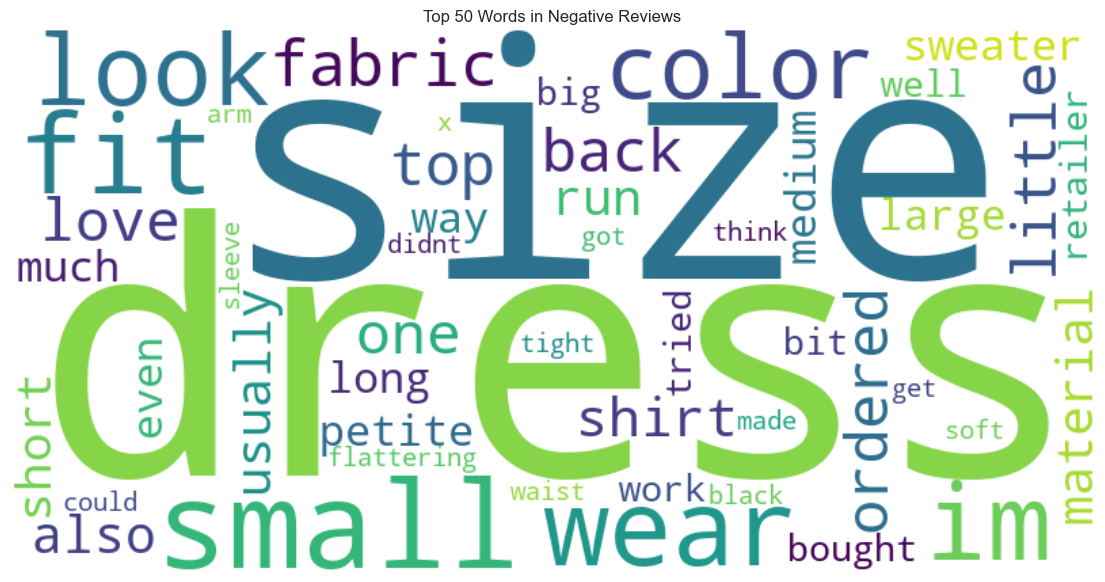

In [62]:
freq_dict=top_50_neg_word["frequency"].to_dict()
wordcloud=WordCloud(width=800, height=400, background_color='white')\
    .generate_from_frequencies(freq_dict)
# Plot the word cloud
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Top 50 Words in Negative Reviews")
plt.show()

# c. Understand sentiment among the customers on the different categories, sub categories,products by location and age group

In [64]:
df.head()

Product ID        Category Subcategory1 SubCategory2   Location Channel  \
2        1077         General      Dresses      Dresses    Gurgaon  Mobile   
3        1049  General Petite      Bottoms        Pants    Chennai     Web   
4         847         General         Tops      Blouses  Bangalore     Web   
5        1080         General      Dresses      Dresses    Gurgaon     Web   
6         858  General Petite         Tops        Knits    Gurgaon  Mobile   

   Customer Age             Review Title  \
2            60  Some major design flaws   
3            50         My favorite buy!   
4            47         Flattering shirt   
5            49  Not for the very petite   
6            39     Cagrcoal shimmer fun   

                                         Review Text  Rating  Recommend Flag  \
2  I had such high hopes for this dress and reall...       3               0   
3  I love, love, love this jumpsuit. it's fun, fl...       5               1   
4  This shirt is very flattering to all due to th...       5               1   
5  I love tracy reese dresses, but this one is no...       2               0   
6  I aded this in my basket at hte last mintue to...       5               1   

   Sentiment_Score Sentiment_Cat  
2         0.073675      Negative  
3         0.550000      Positive  
4         0.512891      Positive  
5         0.178750      Positive  
6         0.133750      Positive

#### Sentiment by Category

In [66]:
sentiment_by_cat=df.groupby("Category")["Sentiment_Cat"].value_counts(normalize=True).unstack()
sentiment_by_cat

Sentiment_Cat   Negative   Neutral  Positive
Category                                    
General         0.174811  0.001372  0.823817
General Petite  0.172470  0.001033  0.826497
Initmates       0.198361       NaN  0.801639

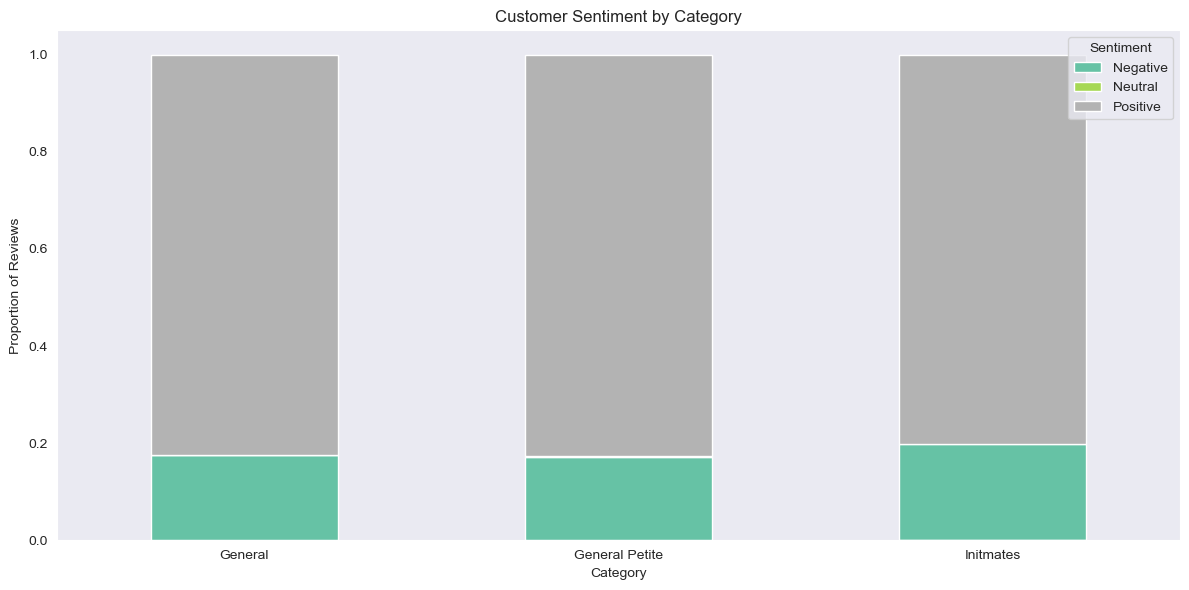

In [67]:
# Visualization
sentiment_by_cat.plot(kind="bar", stacked=True, figsize=(12,6), colormap='Set2')
plt.title("Customer Sentiment by Category")
plt.ylabel("Proportion of Reviews")
plt.xticks(rotation=0)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

#### Sentiment by Subcategory1

In [69]:
sentiment_by_subcat1=df.groupby("Subcategory1")["Sentiment_Cat"].value_counts(normalize=True).unstack()
sentiment_by_subcat1

Sentiment_Cat  Negative   Neutral  Positive
Subcategory1                               
Bottoms        0.175565  0.000314  0.824121
Dresses        0.174828  0.001489  0.823683
Intimate       0.203125       NaN  0.796875
Jackets        0.196815       NaN  0.803185
Tops           0.168254  0.001607  0.830139
Trend          0.252336       NaN  0.747664

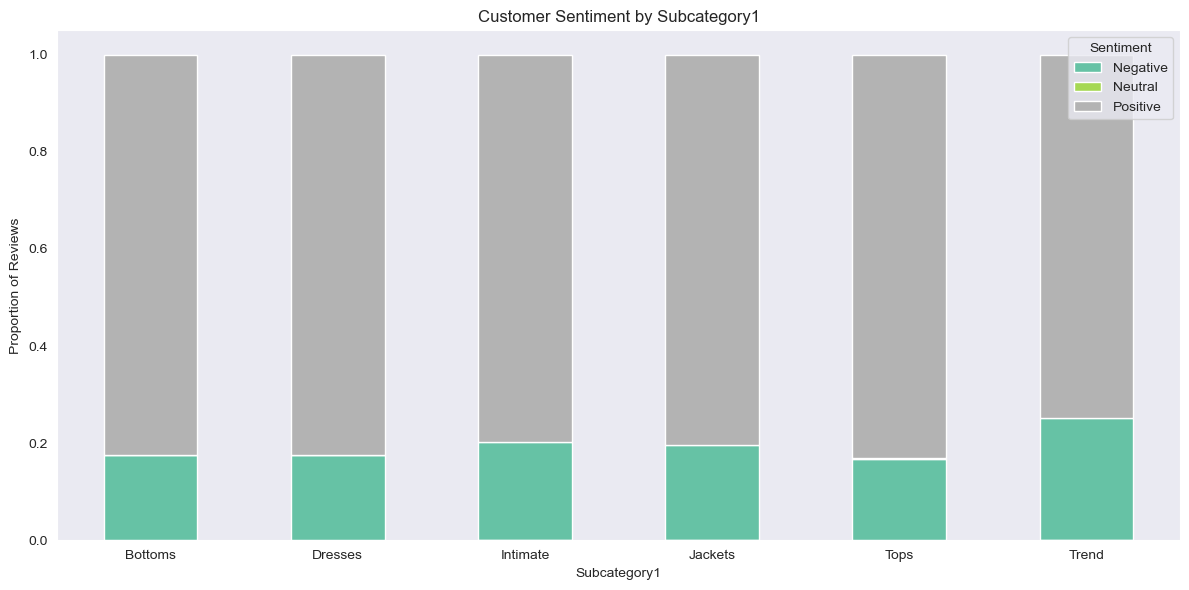

In [70]:
# Visualization
sentiment_by_subcat1.plot(kind="bar", stacked=True, figsize=(12,6), colormap='Set2')
plt.title("Customer Sentiment by Subcategory1")
plt.ylabel("Proportion of Reviews")
plt.xticks(rotation=0)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

#### Sentiment by Subcategory1

In [72]:
sentiment_by_subcat2=df.groupby("SubCategory2")["Sentiment_Cat"].value_counts(normalize=True).unstack()
sentiment_by_subcat2

Sentiment_Cat   Negative   Neutral  Positive
SubCategory2                                
Blouses         0.158871  0.001933  0.839196
Casual bottoms       NaN       NaN  1.000000
Chemises             NaN       NaN  1.000000
Dresses         0.174828  0.001489  0.823683
Fine gauge      0.171521  0.002157  0.826321
Intimates       0.141667       NaN  0.858333
Jackets         0.183946       NaN  0.816054
Jeans           0.169072       NaN  0.830928
Knits           0.169807  0.001256  0.828937
Layering        0.243478       NaN  0.756522
Legwear         0.160305       NaN  0.839695
Lounge          0.217770       NaN  0.782230
Outerwear       0.224199       NaN  0.775801
Pants           0.192740  0.000864  0.806396
Shorts          0.138462       NaN  0.861538
Skirts          0.170854       NaN  0.829146
Sleep           0.201149       NaN  0.798851
Sweaters        0.180624  0.001642  0.817734
Swim            0.204778       NaN  0.795222
Trend           0.252336       NaN  0.747664

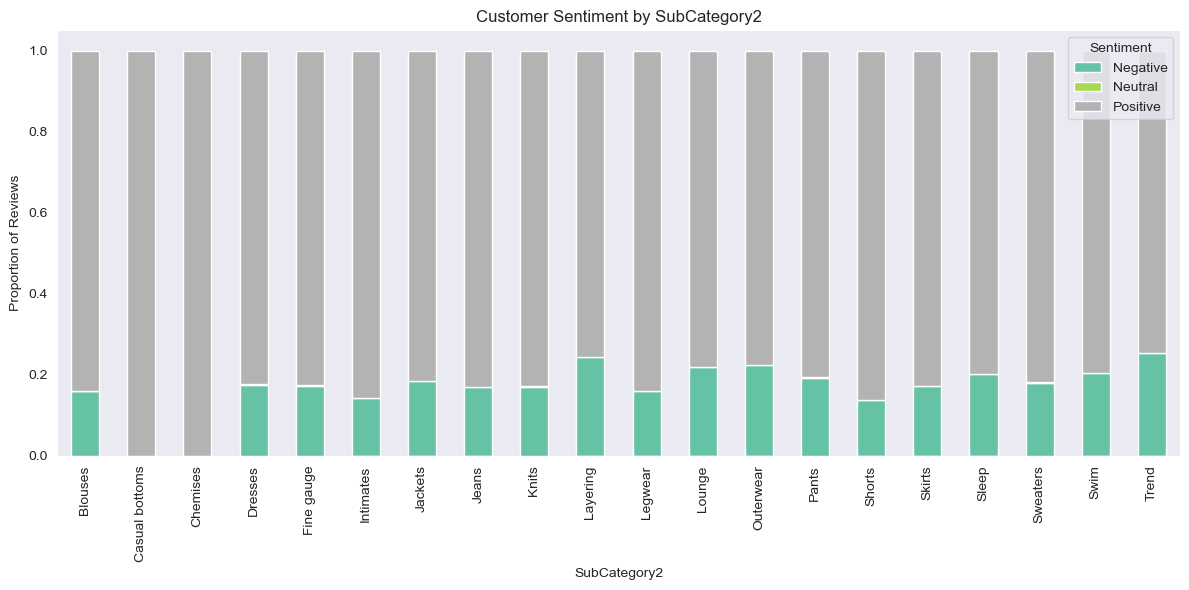

In [73]:
# Visualization
sentiment_by_subcat2.plot(kind="bar", stacked=True, figsize=(12,6), colormap='Set2')
plt.title("Customer Sentiment by SubCategory2")
plt.ylabel("Proportion of Reviews")
plt.xticks(rotation=90)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

#### Sentiment by Location

In [75]:
sentiment_by_loc=df.groupby("Location")["Sentiment_Cat"].value_counts(normalize=True).unstack()
sentiment_by_loc

Sentiment_Cat  Negative   Neutral  Positive
Location                                   
Bangalore      0.176163  0.001362  0.822474
Chennai        0.187851  0.001021  0.811128
Gurgaon        0.175791  0.000951  0.823258
Mumbai         0.170456  0.001347  0.828196

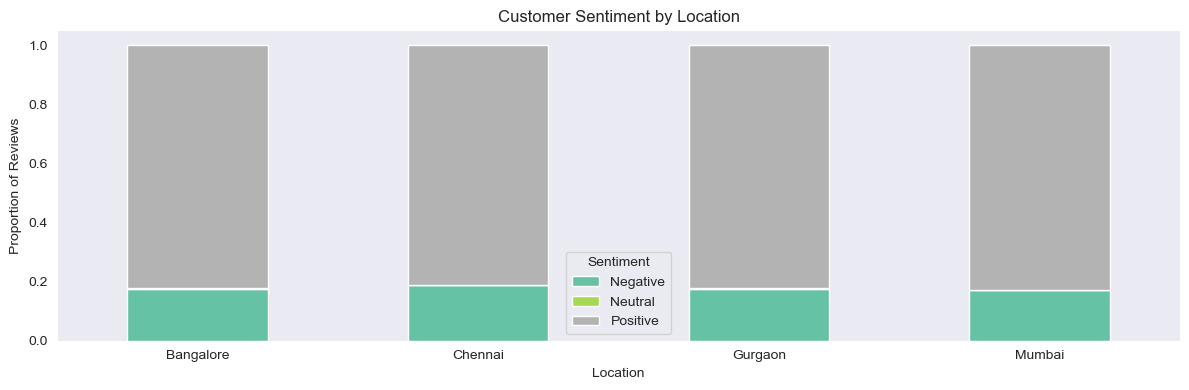

In [76]:
# Visualization
sentiment_by_loc.plot(kind="bar", stacked=True, figsize=(12,4), colormap='Set2')
plt.title("Customer Sentiment by Location")
plt.ylabel("Proportion of Reviews")
plt.xticks(rotation=0)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

#### Sentiment by Channel

In [78]:
sentiment_by_channel=df.groupby("Channel")["Sentiment_Cat"].value_counts(normalize=True).unstack()
sentiment_by_channel

Sentiment_Cat  Negative   Neutral  Positive
Channel                                    
Mobile         0.174828  0.000846  0.824326
Web            0.175928  0.001405  0.822667

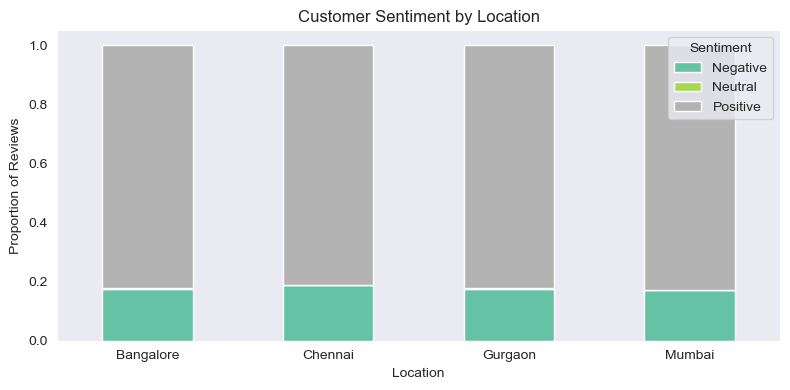

In [79]:
# Visualization
sentiment_by_loc.plot(kind="bar", stacked=True, figsize=(8,4), colormap='Set2')
plt.title("Customer Sentiment by Location")
plt.ylabel("Proportion of Reviews")
plt.xticks(rotation=0)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# d. Perform predictive analytics to understand the drivers of customers who are recommending the products.


In [81]:
df.head(2)

Product ID        Category Subcategory1 SubCategory2 Location Channel  \
2        1077         General      Dresses      Dresses  Gurgaon  Mobile   
3        1049  General Petite      Bottoms        Pants  Chennai     Web   

   Customer Age             Review Title  \
2            60  Some major design flaws   
3            50         My favorite buy!   

                                         Review Text  Rating  Recommend Flag  \
2  I had such high hopes for this dress and reall...       3               0   
3  I love, love, love this jumpsuit. it's fun, fl...       5               1   

   Sentiment_Score Sentiment_Cat  
2         0.073675      Negative  
3         0.550000      Positive

In [82]:
# Cleaning Review Text
df["Review Text"]=df["Review Text"].apply(clean_text)

#### Dummy encode categorical features

In [84]:
cat_var=pd.get_dummies(df[["Category","Subcategory1","SubCategory2","Location","Channel"]] ,drop_first=True)
cat_var.head(3)

Category_General Petite  Category_Initmates  Subcategory1_Dresses  \
2                    False               False                  True   
3                     True               False                 False   
4                    False               False                 False   

   Subcategory1_Intimate  Subcategory1_Jackets  Subcategory1_Tops  \
2                  False                 False              False   
3                  False                 False              False   
4                  False                 False               True   

   Subcategory1_Trend  SubCategory2_Casual bottoms  SubCategory2_Chemises  \
2               False                        False                  False   
3               False                        False                  False   
4               False                        False                  False   

   SubCategory2_Dresses  ...  SubCategory2_Shorts  SubCategory2_Skirts  \
2                  True  ...                False                False   
3                 False  ...                False                False   
4                 False  ...                False                False   

   SubCategory2_Sleep  SubCategory2_Sweaters  SubCategory2_Swim  \
2               False                  False              False   
3               False                  False              False   
4               False                  False              False   

   SubCategory2_Trend  Location_Chennai  Location_Gurgaon  Location_Mumbai  \
2               False             False              True            False   
3               False              True             False            False   
4               False             False             False            False   

   Channel_Web  
2        False  
3         True  
4         True  

[3 rows x 30 columns]

#### Prepare final dataset

In [86]:
df1=df[["Review Text","Customer Age","Rating","Sentiment_Score","Recommend Flag"]].copy()
X=pd.concat([df1.drop(columns="Recommend Flag"),cat_var],axis=1)
y=df1["Recommend Flag"]

### Train-test split

In [88]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13763, 34)
(5899, 34)
(13763,)
(5899,)


## TF-IDF Vectorizer on Review_Text

In [90]:
tfidf=TfidfVectorizer(lowercase=True,stop_words="english",max_features=100,min_df=5,ngram_range=(1,2))
X_train_tfidf=tfidf.fit_transform(X_train["Review Text"])
X_test_tfidf=tfidf.transform(X_test["Review Text"])

#### Numeric + Categorical Features

In [92]:
X_train_extra=sparse.csr_matrix(X_train.drop(columns="Review Text").astype(float))
X_test_extra=sparse.csr_matrix(X_test.drop(columns="Review Text").astype(float))

#### Combine text + extra features

In [94]:
X_train_final=sparse.hstack([X_train_tfidf, X_train_extra])
X_test_final=sparse.hstack([X_test_tfidf, X_test_extra])

# Fit Models and Compare

In [96]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=1),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}
results = {}
for name,model in models.items():
    model.fit(X_train_final,y_train)
    y_pred=model.predict(X_test_final)
    acc=accuracy_score(y_test,y_pred)*100
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    results[name] = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

In [97]:
# Show Results
results_df = pd.DataFrame(results).T.round(4)
print("📊 Model Comparison:")
print(results_df)

📊 Model Comparison:
                     Accuracy  Precision  Recall  F1-Score
Logistic Regression   93.8634     0.9653  0.9592    0.9622
Random Forest         93.6260     0.9719  0.9493    0.9604
XGBoost               93.2361     0.9611  0.9557    0.9584


## We will use Logistic Regression to find  the drivers of customers who are recommending the products

### Feature Importance / Drivers (Logistic Regression)

In [100]:
# Combine tfidf + categorical feature names
tfidf_features=tfidf.get_feature_names_out()
extra_features=X_train.drop(columns="Review Text").columns
all_features=np.concatenate([tfidf_features,extra_features])

In [170]:
# Get top positive coefficients (recommend drivers)
coefficient=models["Logistic Regression"].coef_[0]
top_pos_idx=np.argsort(coefficient)[-20:]
top_features=[(all_features[i], coefficient[i]) for i in top_pos_idx[::-1]]

print("\n Top Drivers for Recommendation (Logistic Regression):")
for feat, val in top_features:
    print(f"{feat}: {val:.4f}")


 Top Drivers for Recommendation (Logistic Regression):
Rating: 3.0062
Sentiment_Score: 1.9003
medium: 1.5972
size: 1.3875
sale: 1.2495
little: 1.1583
worn: 1.1095
definitely: 0.9535
soft: 0.9531
think: 0.9198
petite: 0.9191
nice: 0.8195
wear: 0.7954
im: 0.7912
jean: 0.7828
great: 0.7552
run: 0.7406
bit: 0.7328
summer: 0.6505
black: 0.6404


# e. Create topics and understand themes behind the topics by performing topic mining

### Preprocess the Review Text

In [182]:
df["Clean Review Text"]=df["Review Text"].apply(clean_text)
X=df["Clean Review Text"]

In [186]:
vectorizer=CountVectorizer(max_df=0.95,min_df=5,stop_words="english")
X_dtm=vectorizer.fit_transform(X)

### Fit the LDA Model

In [188]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model=LatentDirichletAllocation(n_components=5,
                                    max_iter=10,
                                    learning_method="online",
                                    random_state=42
                                   )
lda_topics=lda_model.fit_transform(X_dtm)

### Print Top Words per Topic

In [193]:
feature_names=vectorizer.get_feature_names_out()
n_top_words=15
print("\n🔍 Top words per topic:\n")
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"Topic {topic_idx+1}: {' | '.join(top_words)}")


🔍 Top words per topic:

Topic 1: size | fit | small | im | ordered | large | petite | medium | run | lb | usually | wear | xd | little | arm
Topic 2: sweater | store | jacket | retailer | saw | color | soft | green | price | know | coat | heavy | buy | love | online
Topic 3: love | great | wear | fit | color | perfect | jean | comfortable | soft | look | bought | pant | flattering | summer | black
Topic 4: dress | look | fabric | love | beautiful | fit | flattering | color | im | waist | cut | material | skirt | chest | way
Topic 5: shirt | look | color | sleeve | size | model | nice | blue | blouse | fabric | white | bit | photo | bought | ordered
